In [96]:
# 페이스북이 개발한 일변량(하나의 변수) 시계열 예측을 위한 오픈소스 라이브러리
# additive time series forecasting model을 참고해서 구현됨
# 그리고 경향성(Trends), 계절성(seasonality), 휴일(holidays)을 지원하는 모델

# fbprophet설치시, pystan에러가 나는 경우 아래와 같이 pystan 버전을 맞춰줌
!pip install pystan==2.18.0.0
!pip install fbprophet
!pip install plotly
!pip install sklearn
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [97]:
# 버전 확인하기
import fbprophet
print(fbprophet.__version__)

0.7.1


In [98]:
# perphet기본 개념 참고 예제) https://dining-developer.tistory.com/25 
import pandas as pd
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)
print(df.shape)
print(df.head())

(108, 2)
     Month  Sales
0  1960-01   6550
1  1960-02   8728
2  1960-03  12026
3  1960-04  14395
4  1960-05  14587


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


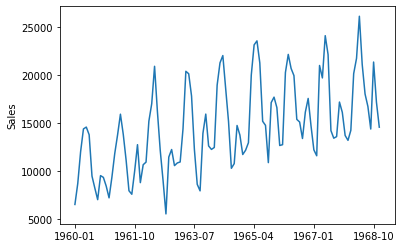

In [99]:
import matplotlib.pyplot as plt

# x축의 데이터 일부분을 뿌려봄
plt.plot(df['Month'], df['Sales'])
plt.xticks([df['Month'].iloc[n] for n in range(0, df.shape[0], int(df.shape[0]*0.2))])
plt.ylabel('Sales')
plt.show()

In [100]:
# 우선 Month가 정말 정렬되어 있는지 확인하기 
new_df = df.sort_values(by='Month')
print((new_df['Month'].values==df['Month'].values).all())

True


In [101]:
# Month부분을 형변환 시킴
# from datetime import datetime
# df['New_Month']= df['Month'].apply(lambda x: datetime.strptime(x, '%Y-%m'))
df['New_Month'] = pd.to_datetime(df['Month'])
print(df.head())
print(df.dtypes)

     Month  Sales  New_Month
0  1960-01   6550 1960-01-01
1  1960-02   8728 1960-02-01
2  1960-03  12026 1960-03-01
3  1960-04  14395 1960-04-01
4  1960-05  14587 1960-05-01
Month                object
Sales                 int64
New_Month    datetime64[ns]
dtype: object


In [102]:
# 학습시킬 데이터 확인
df.rename(columns = {'Sales':'y', 'New_Month':'ds'}, inplace=True)
df.drop(columns=['Month'], inplace=True)
print(df)
print(df.columns)
print('y dtypes= ', df['y'].dtypes)
print('ds dtypes= ', df['ds'].dtypes)

         y         ds
0     6550 1960-01-01
1     8728 1960-02-01
2    12026 1960-03-01
3    14395 1960-04-01
4    14587 1960-05-01
..     ...        ...
103  16722 1968-08-01
104  14385 1968-09-01
105  21342 1968-10-01
106  17180 1968-11-01
107  14577 1968-12-01

[108 rows x 2 columns]
Index(['y', 'ds'], dtype='object')
y dtypes=  int64
ds dtypes=  datetime64[ns]


In [103]:
# train/test data set 나누는 방법은 numpy로도 index를 random하게 shuffle하여 추출할 수도 있지만,
# target에 영향도를 고려한다면, numpy보다는 skitlearn을 이용하는게 좋음
import numpy as np
np.random.seed(42)
index = np.arange(df.shape[0])
print(f"before index={index}")
np.random.shuffle(index)
print(f"changed index={index}")

before index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]
changed index=[ 77  10   4  83  62  67  30  45  95  11  81  79   0  80  18  69  56  76
 106  42  12  36  64  26  22  31  47 100  15  44  88  89   9  33  55 103
  28  40   5  53 107  39  35  16  78  34  66   7  43  65  72  27  19  90
 105  25  68  49  13  24   3  17  38   8  84   6  70  94  99  54  50  73
  46  97  61 104  85  41  58  48  93  57  75  32 101  59  63  91  37  29
  96   1  52  21   2  23  87  98  74  86  82  20  60  71  14  92  51 102]


In [104]:
# !!주의) prophet의 경우, 예측을 트렌드에 맞춰서 하기 때문에 마지막 25%를 test data set으로 남겨야 함.
# 아래와 같이 이가 빠지면 안됨
# import numpy as np
# # sklearn의 train_test_split로 전략적으로 데이터 셋을 훈련/테스트 셋으로 나눌 수 있음.
# # 만약 y값이 0,1 등과 같은 label로 나뉠수 있는 데이터라면 stratify=[y or target numpy]로 설정하면 더 효과적임
# from sklearn.model_selection import train_test_split
#
# car_y_data = df['y'].to_numpy()
# car_ds_data = df['ds'].to_numpy()
# train_ds_data, test_ds_data, train_y_data, test_y_data = train_test_split(car_ds_data, car_y_data,random_state=42)
# # print("train_ds_data", train_ds_data)
# # print("train_y_data", train_y_data)
# print("test_data_data", test_ds_data)
# print("test_y_data", test_y_data)
# print("train datas =>", train_ds_data.shape[0]/df.shape[0], "test datas => ", test_ds_data.shape[0]/df.shape[0])

# 75% : 25% 의 비율로 나
train_data = df[:int(df.shape[0]*0.75)]
test_data = df[int(df.shape[0]*0.75):]
print(df[:int(df.shape[0]*0.75)].shape[0] + df[int(df.shape[0]*0.75):].shape[0] == df.shape[0])

True


In [105]:
# prophet은 dataframe으로 데이터를 학습
from fbprophet import Prophet
model = Prophet()
model.fit(train_data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds          yhat    yhat_lower    yhat_upper
0 1966-10-01  17291.989292  15874.519423  18660.855759
1 1966-11-01  18569.705717  17025.453668  19918.931129
2 1966-12-01  15902.354117  14381.850131  17380.766685
3 1967-01-01  15443.186144  13956.575510  16956.433361
4 1967-02-01  16243.371500  14763.887616  17701.108445


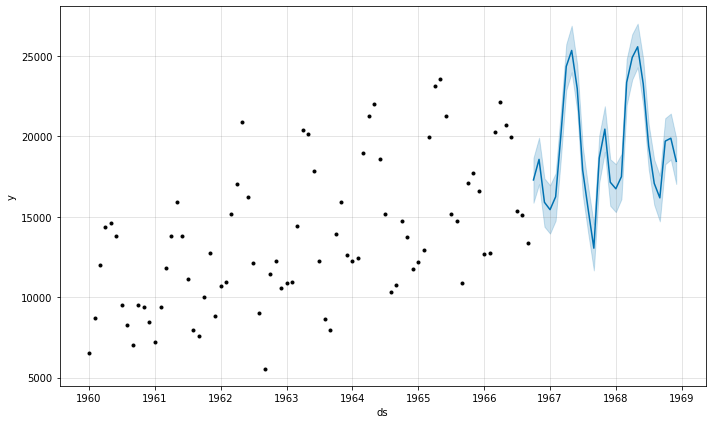

In [106]:
# 예측
y_hat = model.predict(test_data)
print(y_hat[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
model.plot(y_hat)
plt.show()


In [107]:
# 모델 평가
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, mean_squared_error
mae = mean_absolute_error(test_data['y'].values, y_hat['yhat'])
msle = mean_squared_log_error(test_data['y'].values, y_hat['yhat'])

print(f"mae={mae}, msle={msle}")

mae=2298.96221624559, msle=0.02487788801796742


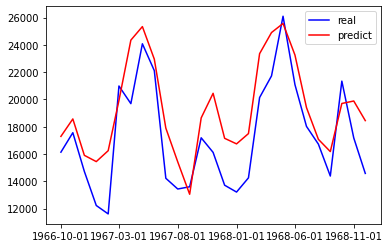

In [108]:
# plot으로 확인하기
plt.plot(test_data['ds'], test_data['y'].values, color='blue', label='real')
plt.plot(test_data['ds'], y_hat['yhat'].values, color='red', label='predict')
plt.xticks([test_data['ds'].iloc[n] for n in range(0, test_data.shape[0], int(test_data.shape[0]*0.2))])
plt.legend()
plt.show()